In [2]:
from blocks.serialization import load
with open('ali_conditional_celeba.tar', 'rb') as src:
    main_loop = load(src)
ali, = main_loop.model.top_bricks
import theano.tensor as tensor
x = tensor.tensor4('features')
y = tensor.matrix('y')


### reconstruction of celebA

In [6]:
# reconstruction

num_examples = 100
from ali import streams
_1, _2, data_stream = streams.create_celeba_data_streams(num_examples,
                                                           num_examples,
                                                           sources=('features', 'targets'),
                                                           )
x, y = next(data_stream.get_epoch_iterator())

In [29]:
y.shape

(100, 40)

In [28]:
z_hat.eval().shape

(100, 256, 1, 1)

In [65]:
embeddings = ali.embedder.apply(y).eval()
z_hat = ali.encoder.apply(x, embeddings).eval()  # G_z(x,e(y))
x_hat = ali.decoder.apply(z_hat, embeddings).eval()  # G_x(z,e(y))

In [66]:
embeddings[0,0],z_hat[0,0],x_hat[0,0,0]

(array([[-0.02875741]], dtype=float32),
 array([[ 0.3754597]], dtype=float32),
 array([ 0.06515606,  0.05046929,  0.05947052,  0.06867982,  0.08713114,
         0.11423713,  0.1015383 ,  0.0992437 ,  0.10564383,  0.10466775,
         0.10789732,  0.08951024,  0.07674231,  0.09640167,  0.09154161,
         0.09370375,  0.08269228,  0.10012411,  0.11453784,  0.09967241,
         0.0789375 ,  0.09569499,  0.11247587,  0.12502323,  0.1395427 ,
         0.14162186,  0.11510228,  0.06630235,  0.04761085,  0.07103887,
         0.12984528,  0.07495899,  0.05460251,  0.06386709,  0.09727613,
         0.04756264,  0.06432787,  0.09174657,  0.11552255,  0.08283605,
         0.09676084,  0.10532611,  0.12186404,  0.10641185,  0.06023468,
         0.06326877,  0.05873523,  0.04345085,  0.02939516,  0.0467289 ,
         0.0286439 ,  0.02807909,  0.02854533,  0.04284602,  0.04505488,
         0.02433571,  0.02352109,  0.02625335,  0.02090435,  0.01890199,
         0.01867045,  0.04518748,  0.03046091

In [64]:
embeddings[0,0],z_hat[0,0],x_hat[0,0,0]

(array([[-0.02875741]], dtype=float32),
 array([[ 0.5856182]], dtype=float32),
 array([ 0.14368916,  0.12439556,  0.16942991,  0.20134775,  0.19695398,
         0.19643141,  0.19506793,  0.18962325,  0.20068301,  0.18053916,
         0.20564511,  0.17695491,  0.19435245,  0.18630366,  0.19733068,
         0.19542201,  0.18593004,  0.19869933,  0.22913286,  0.20827903,
         0.19054213,  0.18664835,  0.21931636,  0.24090946,  0.28089887,
         0.26250091,  0.21191336,  0.1659227 ,  0.18453641,  0.25274494,
         0.36507097,  0.32046351,  0.21438488,  0.19683644,  0.20838007,
         0.19268396,  0.14966172,  0.14610805,  0.16730791,  0.19021448,
         0.16622423,  0.19393289,  0.18323058,  0.17485037,  0.06629398,
         0.08854502,  0.14897679,  0.21387333,  0.22632034,  0.34025156,
         0.09666019,  0.08007369,  0.04811863,  0.09398375,  0.10231492,
         0.0583573 ,  0.0401007 ,  0.04657001,  0.02707369,  0.02749358,
         0.03950079,  0.08188812,  0.04443245

In [62]:
embeddings[0,0],z_hat[0,0],x_hat[0,0,0]

(array([[-0.02875741]], dtype=float32),
 array([[ 0.5164544]], dtype=float32),
 array([ 0.12869695,  0.13375884,  0.10969905,  0.15117881,  0.14948808,
         0.1706178 ,  0.17141357,  0.16457804,  0.17081486,  0.16082284,
         0.17473702,  0.1554555 ,  0.16329356,  0.15550752,  0.15915892,
         0.15612566,  0.15928188,  0.17369722,  0.19741499,  0.18035263,
         0.16051069,  0.1590507 ,  0.16782345,  0.1744896 ,  0.18064786,
         0.16848695,  0.14609344,  0.10550418,  0.09303862,  0.11241636,
         0.15762882,  0.14170067,  0.10453835,  0.13002384,  0.15816143,
         0.11226905,  0.10672832,  0.13343498,  0.13751778,  0.13988684,
         0.13100454,  0.16052915,  0.1572558 ,  0.13937294,  0.08163394,
         0.07410806,  0.07869048,  0.06238896,  0.04259   ,  0.05645633,
         0.03687451,  0.03065673,  0.03201972,  0.04679046,  0.04074898,
         0.03183215,  0.03004919,  0.03519711,  0.02869903,  0.03120799,
         0.03554105,  0.06911241,  0.04362577

In [85]:
embeddings.shape

(100, 256, 1, 1)

In [86]:
embeddings0.shape

(100, 256, 1, 1)

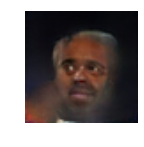

In [114]:
from numpy.random import rand
embeddings = ali.embedder.apply(y).eval()
embeddings[0:1,0+10:20+10,0:1,0:1] = rand(1,20,1,1)
# embeddings[0] = np.zeros((1,256,1,1))
x_hat = ali.decoder.apply(z_hat, embeddings).eval()  # G_x(z,e(y))
plt.figure(figsize=(2,2))
plt.imshow(np.squeeze(np.transpose(x_hat[0],[1,2,0])))
plt.axis('off')
plt.show()

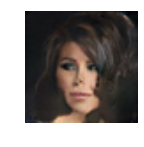

In [32]:
plt.figure(figsize=(2,2))
plt.imshow(np.squeeze(np.transpose(x_hat[0],[1,2,0])))
plt.axis('off')
plt.show()

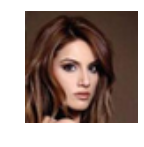

y: [0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 1
 0 0 1]


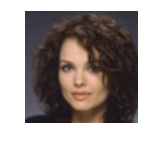

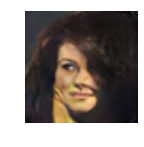

y: [0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0
 0 1 0]


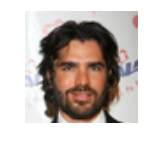

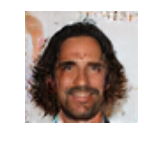

y: [0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 1]


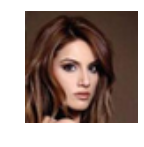

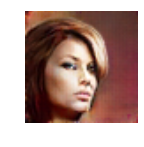

y: [1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 0
 0 1 1]


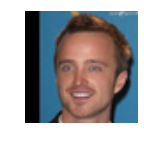

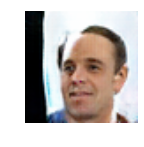

y: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 1]


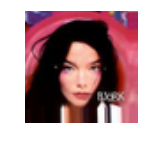

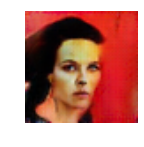

y: [0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1
 0 0 1]


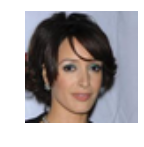

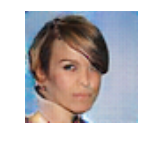

y: [0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1
 0 0 1]


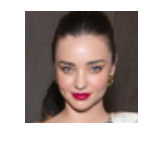

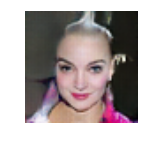

y: [0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0]


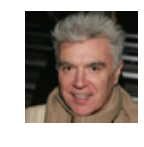

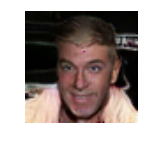

y: [1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1]


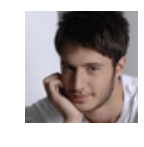

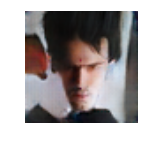

y: [0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 1]


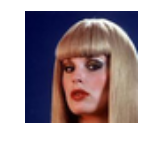

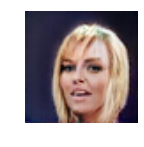

y: [0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 1]


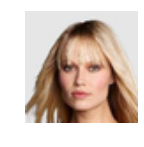

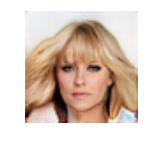

y: [0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1
 1 0 0]


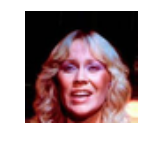

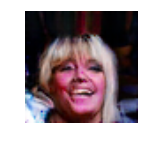

y: [0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1]


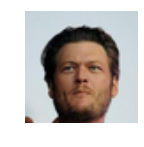

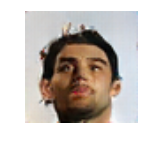

y: [1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1]


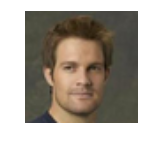

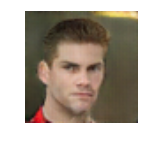

y: [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 1 0]


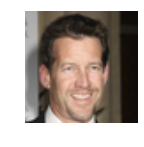

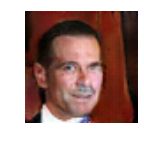

y: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0]


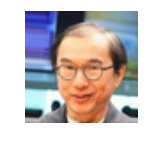

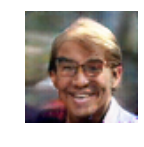

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(2,2))
plt.imshow(np.squeeze(np.transpose(x[2],[1,2,0])))
plt.axis('off')
plt.show()


embeddings = ali.embedder.apply(y)
z_hat = ali.encoder.apply(x, embeddings)  # G_z(x,e(y))
x_hat = ali.decoder.apply(z_hat, embeddings).eval()  # G_x(z,e(y))

% matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
for idx in range(16):
    print('y: {}'.format(y[idx]))
    plt.figure(figsize=(2,2))
#     plt.imshow(np.squeeze(x[idx]))
    plt.imshow(np.squeeze(np.transpose(x[idx],[1,2,0])))
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(2,2))
#     plt.imshow(np.squeeze(x_hat[idx]))
    plt.imshow(np.squeeze(np.transpose(x_hat[idx],[1,2,0])))
    plt.axis('off')
    plt.show()


### CRS DATA

/home/hope-yao/anaconda2/lib/python2.7/site-packages/blocks/bricks/conv.py:344: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  ignore_border=self.ignore_border)


y: [1 1]


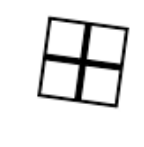

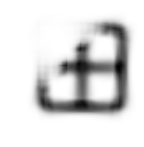

y_hat: [ 0.99892265  1.        ]
y: [1 1]


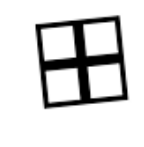

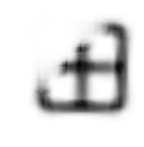

y_hat: [ 0.99937719  1.        ]
y: [0 0]


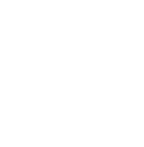

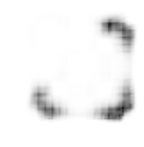

y_hat: [ 0.07214123  0.17378627]
y: [0 0]


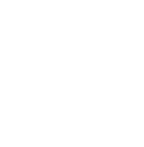

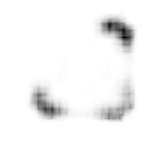

y_hat: [ 0.06339657  0.18453257]
y: [0 1]


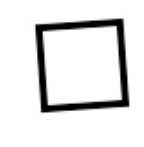

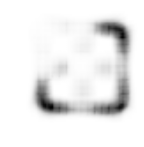

y_hat: [  6.54735253e-04   9.98427153e-01]
y: [1 1]


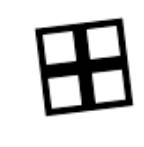

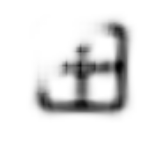

y_hat: [ 0.99736089  1.        ]
y: [0 0]


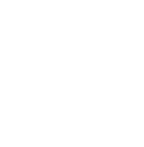

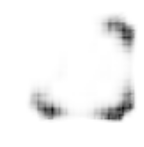

y_hat: [ 0.08906887  0.15536268]
y: [1 1]


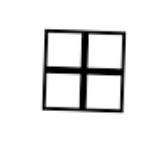

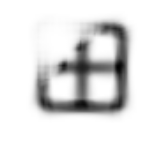

y_hat: [ 0.9979164  1.       ]
y: [0 1]


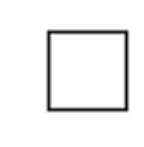

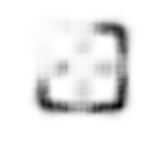

y_hat: [ 0.00208831  0.99999011]
y: [1 1]


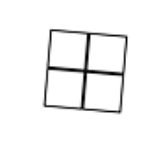

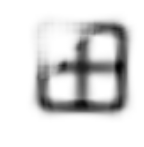

y_hat: [ 0.99618584  1.        ]
y: [0 1]


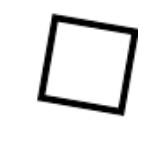

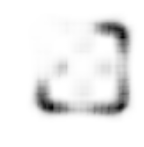

y_hat: [  9.54716699e-04   9.97713923e-01]
y: [0 0]


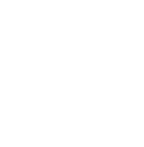

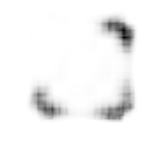

y_hat: [ 0.06280953  0.1860961 ]
y: [0 1]


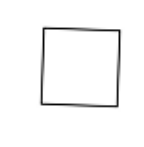

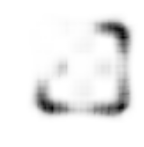

y_hat: [ 0.00165217  0.98433316]
y: [1 1]


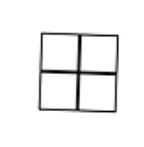

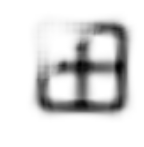

y_hat: [ 0.99848431  1.        ]
y: [0 0]


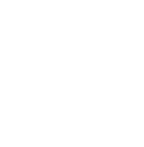

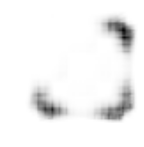

y_hat: [ 0.06160868  0.18816572]
y: [1 1]


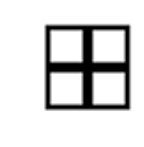

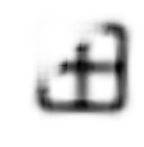

y_hat: [ 0.99930048  1.        ]


In [10]:
# reconstruction

num_examples = 100
from ali import streams
_1, _2, data_stream = streams.create_crs_data_streams(num_examples,
                                                           num_examples,
                                                           sources=('features', 'targets'),
                                                           )
x, y = next(data_stream.get_epoch_iterator())

embeddings = ali.embedder.apply(y)
z_hat = ali.encoder.apply(x, embeddings)  # G_z(x,e(y))
x_hat = ali.decoder.apply(z_hat, embeddings).eval()  # G_x(z,e(y))
y_hat = ali.classifier.apply(x_hat).eval()

% matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
for idx in range(16):
    print('y: {}'.format(y[idx]))
    plt.figure(figsize=(2,2))
    plt.imshow(np.squeeze(x[idx]))
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(2,2))
    plt.imshow(np.squeeze(x_hat[idx]))
    plt.axis('off')
    plt.show()
    print('y_hat: {}'.format(y_hat[idx]))


[1 0]


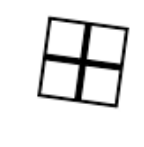

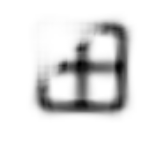

[ 0.9991467  1.       ]
[1 0]


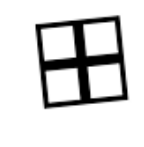

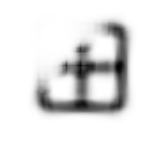

[ 0.99867177  1.        ]
[1 0]


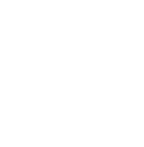

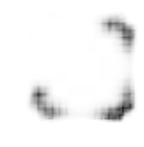

[ 0.08705119  0.15662162]
[1 0]


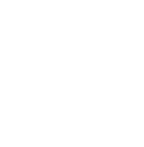

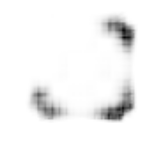

[ 0.08076726  0.16300303]
[1 0]


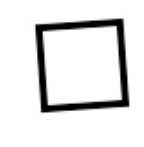

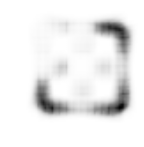

[ 0.0012629   0.99463898]
[1 0]


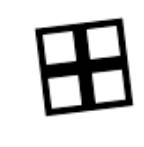

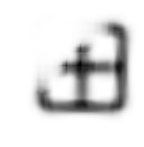

[ 0.99941552  1.        ]
[1 0]


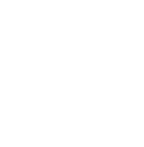

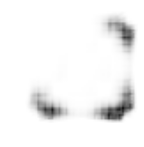

[ 0.08566776  0.15958451]
[1 0]


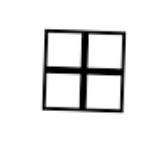

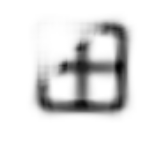

[ 0.99846715  1.        ]
[1 0]


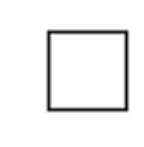

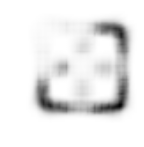

[ 0.00193385  0.99998605]
[1 0]


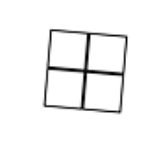

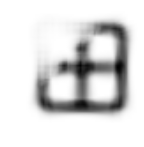

[ 0.99853563  1.        ]
[1 0]


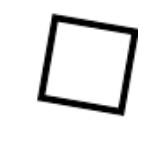

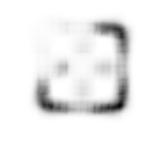

[ 0.00132562  0.99994767]
[1 0]


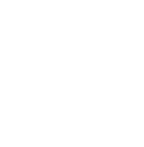

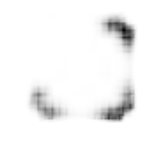

[ 0.09162498  0.15226904]
[1 0]


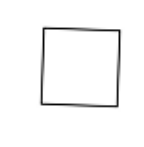

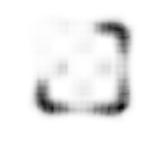

[ 0.001597   0.9885152]
[1 0]


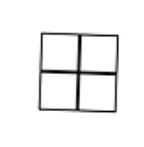

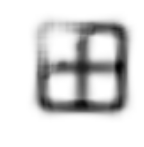

[ 0.98557323  1.        ]
[1 0]


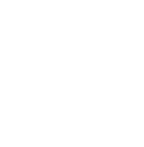

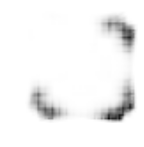

[ 0.10319104  0.1437107 ]
[1 0]


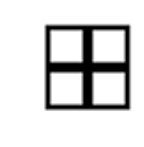

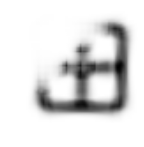

[ 0.99692506  1.        ]


In [11]:
# reduction
yy = np.ones_like(y)
yy[:,1]=0
embeddings = ali.embedder.apply(yy)
z_hat = ali.encoder.apply(x, embeddings)  # G_z(x,e(y))
x_hat = ali.decoder.apply(z_hat, embeddings).eval()  # G_x(z,e(y))
y_hat = ali.classifier.apply(x_hat).eval()
for idx in range(16):
    print(yy[idx])
    plt.figure(figsize=(2,2))
    plt.imshow(np.squeeze(x[idx]))
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(2,2))
    plt.imshow(np.squeeze(x_hat[idx]))
    plt.axis('off')
    plt.show()
    print(y_hat[idx])


In [14]:
yy = np.ones_like(y)
yy[:,1]=0
embeddings = ali.embedder.apply(yy)
z_hat = ali.encoder.apply(x, embeddings)  # G_z(x,e(y))
x_hat = ali.decoder.apply(z_hat, embeddings).eval()  # G_x(z,e(y))
y_hat = ali.classifier.apply(x_hat).eval()
for idx in range(16):
    print(yy[idx])
    plt.figure(figsize=(2,2))
    plt.imshow(np.squeeze(x[idx]))
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(2,2))
    plt.imshow(np.squeeze(x_hat[idx]))
    plt.axis('off')
    plt.show()
    print(y_hat[idx])


(200, 2)

In [13]:
import numpy as np
NLAT = 128
yy = np.asarray([[1,0]]*200)
z_hat = ali.theano_rng.normal(size=(200, NLAT,1,1)).eval()
embeddings = ali.embedder.apply(yy).eval()

In [61]:
x_hat = ali.decoder.apply(z_hat, embeddings).eval()  # G_x(z,e(y))
z_hat.shape, embeddings.shape, x_hat.shape

ERROR (theano.gof.opt): Optimization failure due to: local_conv_gpu_conv
ERROR (theano.gof.opt): node: GpuFromHost(VV8D3SPK_apply_output)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 1922, in process_node
    replacements = lopt.transform(node)
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/opt.py", line 2784, in local_conv_gpu_conv
    inps[1] = as_cuda_ndarray_variable(inps[1])
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/basic_ops.py", line 46, in as_cuda_ndarray_variable
    return gpu_from_host(tensor_x)
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/theano/gof/op.py", line 604, in __call__
    node = self.make_node(*inputs, **kwargs)
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/basic_ops.py", line 132, in make_node
    dtype=x.dt

AssertionError: AbstractConv2d_gradInputs Theano optimization failed: there is no implementation available supporting the requested options. Did you exclude both "conv_dnn" and "conv_gemm" from the optimizer? If on GPU, is cuDNN available and does the GPU support it? If on CPU, do you have a BLAS library installed Theano can link against?

In [65]:
x_hat.shape

(100, 1, 64, 64)

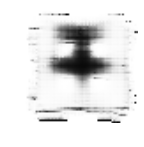

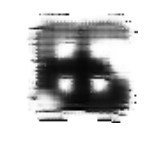

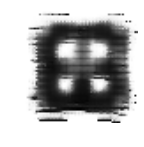

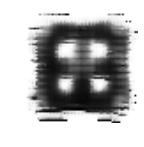

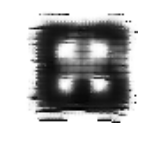

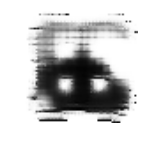

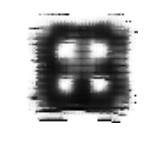

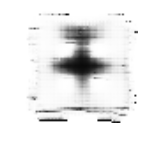

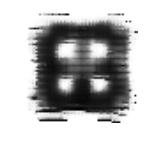

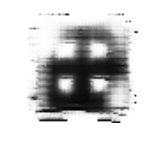

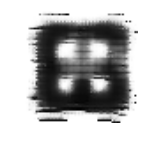

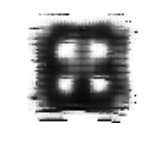

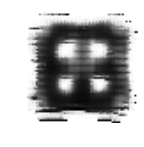

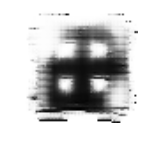

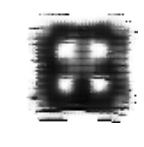

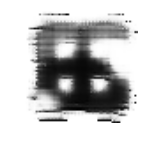

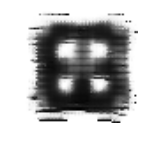

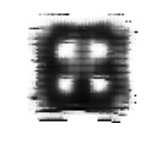

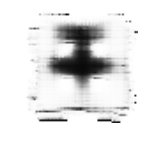

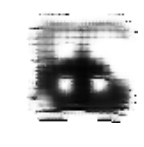

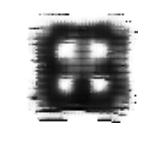

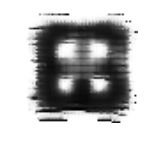

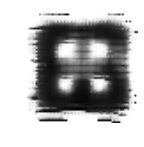

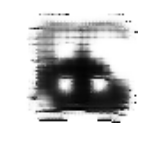

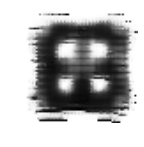

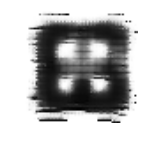

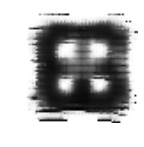

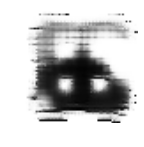

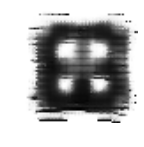

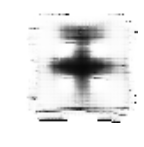

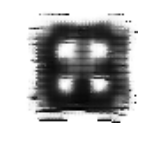

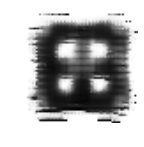

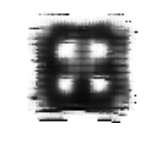

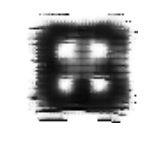

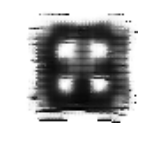

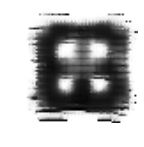

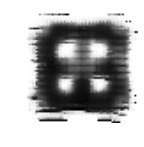

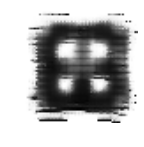

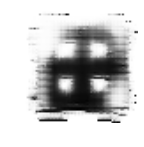

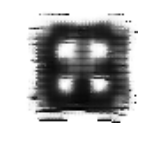

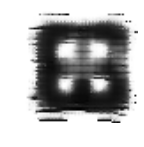

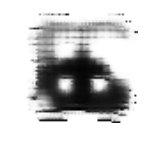

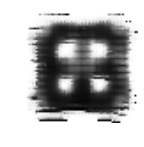

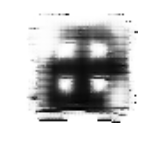

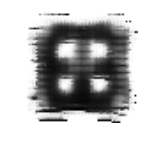

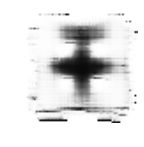

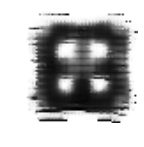

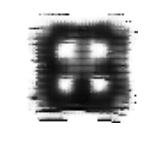

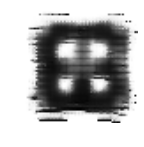

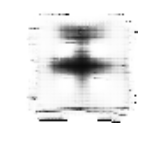

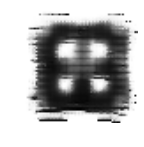

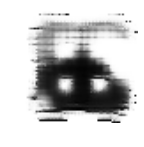

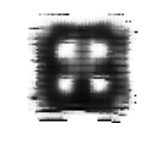

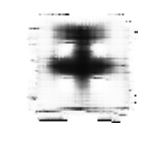

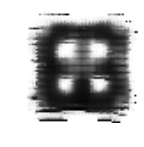

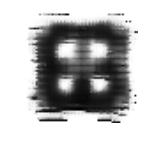

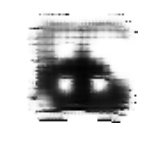

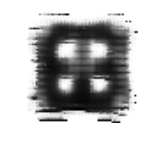

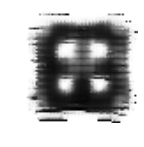

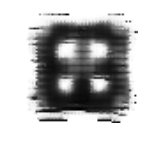

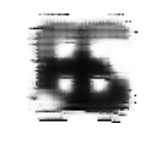

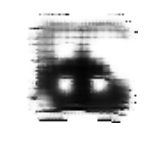

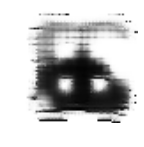

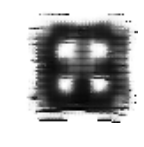

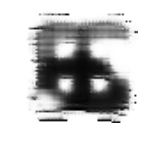

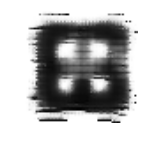

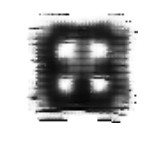

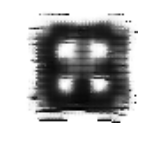

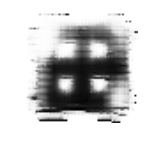

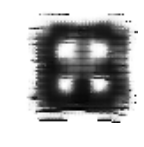

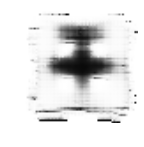

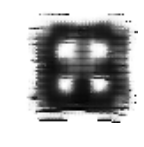

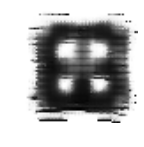

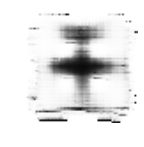

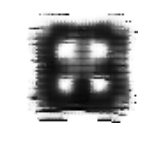

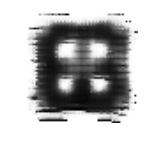

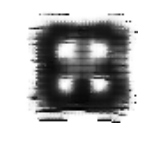

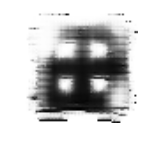

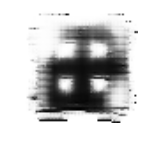

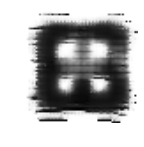

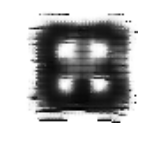

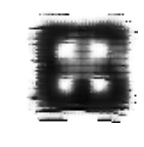

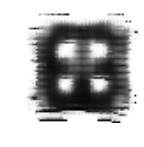

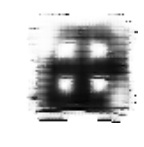

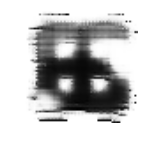

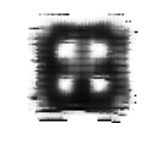

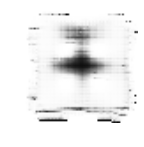

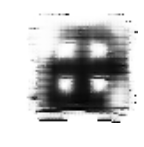

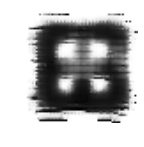

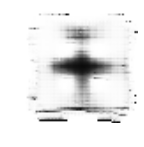

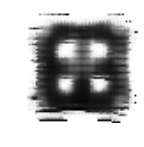

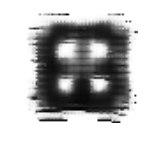

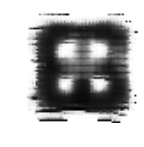

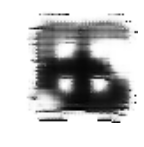

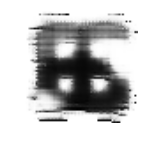

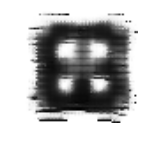

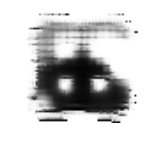

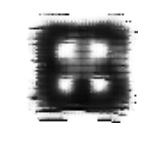

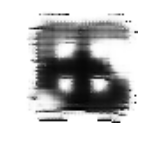

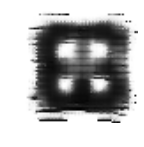

In [62]:
for idx in range(100):
#     print(z_hat[idx])
    plt.figure(figsize=(2,2))
    plt.imshow(np.squeeze(x_hat[idx]))
    plt.axis('off')
    plt.show()


### Add manually labeled data

In [46]:
# %reset
import numpy as np
from random import sample

nn = np.load('/home/hope-yao/Documents/Data/rec_crs.npy')
dim = 64

crs = nn.item()['rectcrs_img']#['cross_img']
crs = crs.reshape(crs.shape[0],1,dim,dim)
# crs_label = [[1,0]+[0]*0] * crs.shape[0]
crs_label = [[1,1]+[0]*0] * crs.shape[0]

rec = nn.item()['rect_img']
rec = rec.reshape(rec.shape[0],1,dim,dim)
rec_label = [[0,1]+[0]*0] * rec.shape[0]

datas = np.append(crs,rec,0)
labels = np.append(crs_label,rec_label,0)

ttn = 128*4
data = [datas[len(datas)/ttn*i] for i in range(ttn) ]
label = [labels[len(datas)/ttn*i] for i in range(ttn) ]
data = np.append(data,x_hat,0)
label = np.append(label,[[0,0]]*len(x_hat),0)
data = np.asarray(data)
label = np.asarray(label)

split = 0.2
l = len(data) #length of data
n1 = int(split*l)  # split for testing
n2 = l - n1
indices = sample(range(l),n1)

data_test = data[indices]
label_test = label[indices]

data_train = np.delete(data,indices,0)
label_train = np.delete(label,indices,0)

In [50]:
# %reset
import h5py

train_features = []
train_targets = []
test_features = []
test_targets = []
for index, array in enumerate(data_train):
    train_features.append(array.reshape(array.shape[0],array.shape[1],array.shape[2]))
    train_targets.append(label_train[index])
for index, array in enumerate(data_test):
    test_features.append(array.reshape(array.shape[0],array.shape[1],array.shape[2]))
    test_targets.append(label_test[index])

train_features = np.array(train_features)
train_targets = np.array(train_targets) #starts from 0
test_features = np.array(test_features)
test_targets = np.array(test_targets)
train_n, c, p1, p2 = train_features.shape
test_n = test_features.shape[0]
n = train_n + test_n

f = h5py.File('rectcrs.hdf5', mode='w')
features = f.create_dataset('features', (n, c, p1, p2), dtype='uint8')
m = 2
targets = f.create_dataset('targets', (n, m), dtype='uint8')

features[...] = np.vstack([train_features, test_features])
targets[...] = np.vstack([train_targets, test_targets]).reshape(n,m)

features.dims[0].label = 'batch'
features.dims[1].label = 'channel'
features.dims[2].label = 'height'
features.dims[3].label = 'width'
targets.dims[0].label = 'batch'
targets.dims[1].label = 'targets'


from fuel.datasets.hdf5 import H5PYDataset
split_dict = {
    'train': {'features': (0, train_n), 'targets': (0, train_n)},
    'valid': {'features': (train_n, n), 'targets': (train_n, n)}}
f.attrs['split'] = H5PYDataset.create_split_array(split_dict)

f.flush()
f.close()

## MNIST DATASET

In [21]:
% reset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
(mnist.train.images).shape, (mnist.train.labels).shape

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


((55000, 784), (55000, 10))

In [3]:
# %reset
import numpy as np
import h5py
data_train = mnist.train.images
label_train = mnist.train.labels
data_test = mnist.test.images
label_test = mnist.test.labels

train_features = []
train_targets = []
test_features = []
test_targets = []
for index, array in enumerate(data_train):
    train_features.append(array.reshape(1,28,28))
    train_targets.append(label_train[index])
for index, array in enumerate(data_test):
    test_features.append(array.reshape(1,28,28))
    test_targets.append(label_test[index])

train_features = np.array(train_features)
train_targets = np.array(train_targets) #starts from 0
test_features = np.array(test_features)
test_targets = np.array(test_targets)
train_n, c, p1, p2 = train_features.shape
test_n = test_features.shape[0]
n = train_n + test_n

f = h5py.File('Mnist28.hdf5', mode='w')
features = f.create_dataset('features', (n, c, p1, p2), dtype='uint8')
m = 10
targets = f.create_dataset('targets', (n, m), dtype='uint8')

features[...] = np.vstack([train_features, test_features])
targets[...] = np.vstack([train_targets, test_targets]).reshape(n,m)

features.dims[0].label = 'batch'
features.dims[1].label = 'channel'
features.dims[2].label = 'height'
features.dims[3].label = 'width'
targets.dims[0].label = 'batch'
targets.dims[1].label = 'targets'


from fuel.datasets.hdf5 import H5PYDataset
split_dict = {
    'train': {'features': (0, train_n), 'targets': (0, train_n)},
    'valid': {'features': (train_n, n), 'targets': (train_n, n)}}
f.attrs['split'] = H5PYDataset.create_split_array(split_dict)

f.flush()
f.close()

NameError: name 'np' is not defined

## MNIST64 DATASET

In [22]:
import numpy as np
labels = mnist.train.labels
idx0 = []
idx1 = []
for i in range(mnist.train.labels.shape[0]):
    tmp = np.argmax(mnist.train.labels[i,:])
    if tmp == 0:
        idx0 = idx0 + [i]
    if tmp == 1:
        idx1 = idx1 + [i]

In [ ]:
images = mnist.train.images
data = []
label = []
pad = 2
nbatch = 4000

for j in range(128*nbatch):
    imgs = np.zeros((64,64))
    labeli = []
    for i in range(4):
        # upperleft, lowerleft, upperright, lowerright
        kk = np.int(np.random.rand(1)[0]+0.5)
        if kk:
            img = images[np.random.choice(idx1)].reshape(28,28)
        else:
            img = images[np.random.choice(idx0)].reshape(28,28)
        if i==0:
            imgs[0+pad:28+pad,0+pad:28+pad] = img
        if i==1:
            imgs[28+pad+2*pad:2*28+pad+2*pad,0+pad:28+pad] = img
        if i==2:
            imgs[0+pad+2*pad:28+pad+2*pad,28+pad:2*28+pad] = img
        if i==3:
            imgs[28+pad+2*pad:2*28+pad+2*pad,28+pad+2*pad:2*28+pad+2*pad] = img
        labeli = labeli +[kk] 
    label = label + [labeli] 
    data = data + [imgs]
data = np.asarray(data)
label = np.asarray(label)

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
idx = 2
plt.imshow(np.squeeze(data[idx]))
print(label[idx])
plt.show()

In [ ]:
import numpy as np
from random import sample

split = 0.2
l = len(data) #length of data
n1 = int(split*l)  # split for testing
n2 = l - n1
indices = sample(range(l),n1)

data = data.reshape(data.shape[0],1,data.shape[1],data.shape[2])
data_test = data[indices]
label_test = label[indices]

data_train = np.delete(data,indices,0)
label_train = np.delete(label,indices,0)

In [ ]:
# %reset
import h5py

train_features = []
train_targets = []
test_features = []
test_targets = []
for index, array in enumerate(data_train):
    train_features.append(array.reshape(array.shape[0],array.shape[1],array.shape[2]))
    train_targets.append(label_train[index])
for index, array in enumerate(data_test):
    test_features.append(array.reshape(array.shape[0],array.shape[1],array.shape[2]))
    test_targets.append(label_test[index])

train_features = np.array(train_features)
train_targets = np.array(train_targets) #starts from 0
test_features = np.array(test_features)
test_targets = np.array(test_targets)
train_n, c, p1, p2 = train_features.shape
test_n = test_features.shape[0]
n = train_n + test_n

f = h5py.File('Mnist64.hdf5', mode='w')
features = f.create_dataset('features', (n, c, p1, p2), dtype='uint8')
m = 4
targets = f.create_dataset('targets', (n, m), dtype='uint8')

features[...] = np.vstack([train_features, test_features])
targets[...] = np.vstack([train_targets, test_targets]).reshape(n,m)

features.dims[0].label = 'batch'
features.dims[1].label = 'channel'
features.dims[2].label = 'height'
features.dims[3].label = 'width'
targets.dims[0].label = 'batch'
targets.dims[1].label = 'targets'


from fuel.datasets.hdf5 import H5PYDataset
split_dict = {
    'train': {'features': (0, train_n), 'targets': (0, train_n)},
    'valid': {'features': (train_n, n), 'targets': (train_n, n)}}
f.attrs['split'] = H5PYDataset.create_split_array(split_dict)

f.flush()
f.close()

In [310]:
from theano import tensor
from blocks.bricks import LeakyRectifier, Logistic, Rectifier, Softmax, Activation
from ali.conditional_bricks import (EncoderMapping, Decoder,
                                    GaussianConditional, XZYJointDiscriminator,
                                    ConditionalALI, LeNet)
from blocks.initialization import IsotropicGaussian, Constant, Uniform

NCLASSES = 4
feature_maps = [16, 32, 64]
mlp_hiddens = [100]
output_size = NCLASSES
image_size = (64, 64)

conv_activations = [Rectifier() for _ in feature_maps]
mlp_activations = [Rectifier() for _ in mlp_hiddens] + [Logistic()]
convnet = LeNet(conv_activations, 1, image_size,
                filter_sizes=[(3, 3), (3, 3), (3, 3)],
                feature_maps=feature_maps,
                pooling_sizes=[(2, 2), (2, 2), (2, 2)],
                top_mlp_activations=mlp_activations,
                top_mlp_dims=mlp_hiddens + [output_size],
                border_mode='valid',
                weights_init=Uniform(width=.5),
                biases_init=Constant(0)
                )

convnet.push_initialization_config()
convnet.initialize()

classifier = convnet
x = tensor.tensor4('features')
y = tensor.matrix('targets')
BATCH_SIZE = 128
pred = classifier.apply(x)
EPS = 1e-8
classifier_cost = - ( tensor.sum(y*tensor.log(pred+EPS)) + tensor.sum((1-y)*tensor.log(1-pred+EPS)) )
# classifier_error = tensor.sum(tensor.sqr(y - pred))/BATCH_SIZE/NCLASSES
# pred = generator.apply(data_test).eval()
classifier_error = tensor.sum(tensor.abs_(y-pred))/BATCH_SIZE/NCLASSES
classifier_cost.name = 'classifier cost'
classifier_error.name = 'classifier error'


In [305]:
pred = np.asarray([[1,0],[0,0.8]])
y = np.asarray([[1,0],[0,1]])
classifier_cost = - ( tensor.sum(y*tensor.log(pred+EPS)) + tensor.sum((1-y)*tensor.log(1-pred+EPS)) )


In [314]:
from blocks.algorithms import GradientDescent, CompositeRule, Restrict, Scale
from collections import OrderedDict
from theano import grad
from blocks.algorithms import Adam, RMSProp, Momentum
from blocks.select import Selector
from blocks.extensions import FinishAfter, Timing, Printing, ProgressBar
from blocks.extensions.monitoring import DataStreamMonitoring
from ali.streams import create_celeba_data_streams, create_crs_data_streams, create_mnist64_data_streams
from blocks.extensions.saveload import Checkpoint
from blocks.main_loop import MainLoop
from blocks.model import Model

MONITORING_BATCH_SIZE = 128
streams = create_mnist64_data_streams(BATCH_SIZE, MONITORING_BATCH_SIZE,
                                     sources=('features', 'targets'))
main_loop_stream, train_monitor_stream, valid_monitor_stream = streams

classifier_parameters = list(Selector([classifier]).get_parameters().values())
LEARNING_RATE_C = 1e-2
# step_rule_c = RMSProp(learning_rate=LEARNING_RATE_C)
# # step_rule_c = Momentum(learning_rate=LEARNING_RATE_C,momentum = 0.99)

# gradients = OrderedDict()
# gradients.update(
#     zip(classifier_parameters,
#         grad(classifier_cost, classifier_parameters)))
# classify_algorithm = GradientDescent(cost=classifier_cost,
#                                     gradients=gradients,
#                                     parameters=classifier_parameters,
#                                     step_rule=step_rule_c)

classify_algorithm = GradientDescent(
    cost=classifier_cost, parameters=classifier_parameters,
    step_rule=Scale(learning_rate=0.0001))

# classifier_monitor = ()
extensions = [
    Timing(),
    FinishAfter(after_n_epochs=100),
    DataStreamMonitoring(
        [classifier_cost, classifier_error], train_monitor_stream, prefix="train"),
    DataStreamMonitoring(
        [classifier_cost, classifier_error], valid_monitor_stream, prefix="valid"),
    Checkpoint('./test.ckpt', after_epoch=True, after_training=True,
               use_cpickle=True),
    ProgressBar(),
    Printing(),
]
classify_loop = MainLoop(data_stream=main_loop_stream,
                         algorithm=classify_algorithm,
                         model=Model(classifier_cost), 
                         extensions=extensions)
print('classifier training...')
classify_loop.run()
print('classifier training done...')

classifier training...

-------------------------------------------------------------------------------
BEFORE FIRST EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 0
	 received_first_batch: False
	 resumed_from: None
	 training_started: True
Log records from the iteration 0:
	 time_initialization: 1.74006009102
	 train_classifier cost: nan
	 train_classifier error: nan
	 valid_classifier cost: nan
	 valid_classifier error: nan



Epoch 0, step 32 |######################################| Elapsed Time: 0:00:02



-------------------------------------------------------------------------------
AFTER ANOTHER EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: False
	 epochs_done: 1
	 iterations_done: 32
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 32:
	 saved_to: ('./test.ckpt',)
	 time_read_data_this_epoch: 0.089875459671
	 time_read_data_total: 0.089875459671
	 time_train_this_epoch: 0.330967903137
	 time_train_total: 0.330967903137
	 train_classifier cost: nan
	 train_classifier error: nan
	 valid_classifier cost: nan
	 valid_classifier error: nan



Epoch 1, step 32 |######################################| Elapsed Time: 0:00:02



-------------------------------------------------------------------------------
AFTER ANOTHER EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: True
	 epoch_started: False
	 epochs_done: 2
	 iterations_done: 64
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 64:
	 epoch_interrupt_received: True
	 saved_to: ('./test.ckpt',)
	 time_read_data_this_epoch: 0.0901803970337
	 time_read_data_total: 0.180055856705
	 time_train_this_epoch: 0.593623638153
	 time_train_total: 0.92459154129
	 train_classifier cost: nan
	 train_classifier error: nan
	 valid_classifier cost: nan
	 valid_classifier error: nan


-------------------------------------------------------------------------------
TRAINING HAS BEEN FINISHED:
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_

In [255]:
# % reset
from blocks.serialization import load

main_loop = load(open('test.ckpt', "rb"))
generator = main_loop.model.get_top_bricks()[-1]

In [256]:
from ali.streams import create_celeba_data_streams, create_crs_data_streams, create_mnist64_data_streams
BATCH_SIZE = 128
MONITORING_BATCH_SIZE = 128

streams = create_mnist64_data_streams(BATCH_SIZE, MONITORING_BATCH_SIZE,
                                     sources=('features', 'targets'))
main_loop_stream, train_monitor_stream, valid_monitor_stream = streams

In [257]:
train_test, label_test = next(valid_monitor_stream.data_stream.get_epoch_iterator())

In [258]:
from theano import tensor

pred = generator.apply(train_test).eval()
(tensor.sum(tensor.abs_(label_test-pred))/BATCH_SIZE).eval()
# np.sum(abs(label_test-pred))/len(label_test)

ERROR (theano.gof.opt): Optimization failure due to: local_conv_gpu_conv
ERROR (theano.gof.opt): node: AbstractConv2d{convdim=2, border_mode='valid', subsample=(1, 1), filter_flip=True, imshp=(None, 32, 14, 14), kshp=(64, 32, 3, 3), filter_dilation=(1, 1)}(pool_1_apply_output, HostFromGpu.0)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/theano/gof/opt.py", line 1922, in process_node
    replacements = lopt.transform(node)
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/opt.py", line 2809, in local_conv_gpu_conv
    inps[0] = as_cuda_ndarray_variable(inps[0])
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/basic_ops.py", line 46, in as_cuda_ndarray_variable
    return gpu_from_host(tensor_x)
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/theano/gof/op.py", line 604, in __call__
    node = self.make_no

array(1.9339765682911578)

In [200]:
(pred+0.5).astype(int)

array([[1, 0, 0, 1],
       [0, 0, 0, 0],
       [0, 1, 1, 1],
       [1, 1, 1, 0],
       [1, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 1, 0, 0],
       [0, 1, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 1, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [1, 1, 0, 0],
       [0, 0, 1, 1],
       [1, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 1, 1, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 1, 0, 1],
       [1, 1, 0, 1],
       [0, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 1, 1],
       [0, 0,

In [192]:
label_test

array([[1, 1, 0, 1],
       [0, 0, 0, 0],
       [0, 1, 1, 1],
       [0, 1, 1, 1],
       [1, 1, 0, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 1, 1, 0],
       [1, 1, 0, 0],
       [0, 1, 0, 1],
       [1, 0, 0, 0],
       [1, 1, 1, 1],
       [0, 1, 1, 0],
       [0, 1, 0, 1],
       [1, 0, 1, 1],
       [0, 1, 1, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 1, 0, 0],
       [1, 1, 0, 0],
       [0, 0, 0, 1],
       [1, 1, 0, 1],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [1, 0, 1, 1],
       [1, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 1, 0, 1],
       [1, 0, 1, 1],
       [0, 1, 1, 0],
       [1, 1, 0, 1],
       [0, 1, 1, 1],
       [1, 0, 1, 1],
       [1, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 1, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [1, 1, 0, 0],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [0, 1, 1, 1],
       [0, 1, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 1],
       [0, 0,

### Keras MNIST64

In [17]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
epochs = 12


img_rows, img_cols = 64, 64
num_classes = 4
from fuel.datasets import MNIST28, MNIST64
from fuel.streams import DataStream
from fuel.schemes import ShuffledScheme
import numpy as np
mnist_test = MNIST64(("valid",))
mnist_test_stream = DataStream.default_stream(
    mnist_test,
    iteration_scheme=ShuffledScheme(
        mnist_test.num_examples, batch_size))
x,y = mnist_test_stream.data_stream.data_stream.dataset.data_sources
if K.image_data_format() == 'channels_first':
    x = x.reshape(x.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x = x.reshape(x.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
x_train, x_test = x[0:np.int(0.8*len(x))], x[np.int(0.8*len(x)):]
y_train, y_test = y[0:np.int(0.8*len(x))], y[np.int(0.8*len(x)):]
print(x_train.shape,y_train.shape)

# # input image dimensions
# num_classes = 10
# img_rows, img_cols = 28, 28
#
# # the data, shuffled and split between train and test sets
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
#
# if K.image_data_format() == 'channels_first':
#     x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
#     x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
#     x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
#     x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
#     input_shape = (img_rows, img_cols, 1)
#
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255
# print('x_train shape:', x_train.shape)
# print(x_train.shape[0], 'train samples')
# print(x_test.shape[0], 'test samples')
#
# # convert class vectors to binary class matrices
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
          verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

(819, 64, 64, 1) (819, 4)
Train on 819 samples, validate on 205 samples
Epoch 1/12
819/819 [==============================] - 0s - loss: 2.8827 - acc: 0.3785 - val_loss: 2.7779 - val_acc: 0.5756
Epoch 2/12
819/819 [==============================] - 0s - loss: 2.7767 - acc: 0.4469 - val_loss: 2.7356 - val_acc: 0.2390
Epoch 3/12
819/819 [==============================] - 0s - loss: 2.6848 - acc: 0.4860 - val_loss: 2.6471 - val_acc: 0.4146
Epoch 4/12
819/819 [==============================] - 0s - loss: 2.6109 - acc: 0.4628 - val_loss: 2.5693 - val_acc: 0.4390
Epoch 5/12
819/819 [==============================] - 0s - loss: 2.5273 - acc: 0.5043 - val_loss: 2.5773 - val_acc: 0.3659
Epoch 6/12
819/819 [==============================] - 0s - loss: 2.4555 - acc: 0.5067 - val_loss: 2.5537 - val_acc: 0.3512
Epoch 7/12
819/819 [==============================] - 0s - loss: 2.4092 - acc: 0.5067 - val_loss: 2.5420 - val_acc: 0.3854
Epoch 8/12
819/819 [==============================] - 0s - loss: 2.

In [18]:
y_pred=model.predict_proba(x_test)

 32/205 [===>..........................] - ETA: 0s

In [19]:
np.sum(np.abs(y_test[0:100] - (y_pred[0:100]+0.5).astype('int')))

109

array([[1, 0, 0, 1],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 1, 1, 0],
       [0, 1, 1, 1],
       [1, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 0, 1, 1]])